In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [2]:
def fun_gru(x):   #used in gru for 1-i part
    return 1-x

<h3><center>Generating data</center></h3>

In [3]:
def generate_data(n):
    x = []
    y = []
    for i in range(n):
        length = random.randint(2,9) #(min,max) limit
        x_1 = torch.rand(length)
        x_2 = torch.zeros(length,dtype=torch.int32)
        #generate two unique positions in length 
        lt = []
        while (len(lt) < 2):
            k = random.randint(0,length - 1)
            if(lt.count(k) == 0):
                lt.append(k)
                x_2[k] = 1
        lt = []
        
        sum = torch.tensor([0.0])
        for j in range(length):
            if x_2[j] == 1:    #during comparing take care that int type of tensor is compared
                sum = sum + x_1[j]
        x_3 = torch.cat((x_1,x_2)).reshape(2,length).T
        y.append(sum)
        x.append(x_3)
    return x,y

<p>The generated data represents a synthetic dataset for a supervised learning task. The inputs (x) are generated as follows:</p>

* For each instance, a random length (between 2 and 9) is generated.
* Two unique positions within the length are randomly selected.
* A tensor x_1 of shape (length,) is generated with random values between 2 and 9.
* A tensor x_2 of shape (length,) is created with all values initialized to 0.
* The selected positions in x_2 are set to 1.
* The values in x_1 corresponding to the positions where x_2 is 1 are summed, and the result is stored in y.
* Finally, x, which contains both x_1 and x_2, is reshaped into shape (length, 2) and transposed to have shape (2, length).

In [4]:
x_train,y_train = generate_data(6000)
x_test,y_test = generate_data(2000)

print(x_train[0])
print(y_train[0]) #we want to train the network to sum when x[i][1] == 1

tensor([[0.7588, 0.0000],
        [0.5858, 0.0000],
        [0.5342, 1.0000],
        [0.5350, 1.0000],
        [0.8444, 0.0000],
        [0.3711, 0.0000]])
tensor([1.0692])


<h3><center>Elmon RNN</center></h3>

In [6]:
class elmon(nn.Module):
    error_pred = []
    error_baseline = 0
    noof_epochs = 0
    def __init__(self):
        super().__init__()
        #intitial hidden state rather then zeros we can learn them from training data
        self.s_0 = nn.Parameter(torch.randn(3,1,requires_grad = True))
        
        self.W_i = nn.Parameter(torch.randn(3,2,requires_grad = True)) #multiplied with input
        self.W_h = nn.Parameter(torch.randn(3,3,requires_grad = True)) #multiplied with hidden staes
        self.W_o = nn.Parameter(torch.randn(1,3,requires_grad = True)) #multiplied with output
        
        self.b = nn.Parameter(torch.randn(3,1,requires_grad = True))  #biases of hidden state
        self.c = nn.Parameter(torch.randn(1,1,requires_grad = True))   #biases of final output
    
    def forward(self,x):
        hidden_state = self.s_0
        for i in range(len(x)):
            hidden_state = torch.tanh(self.W_i@x[i] + self.W_h@hidden_state + self.b) #x[i] is 2*1 dimention
        y = self.W_o@hidden_state + self.c
        return y
    
    def train(self,loss_function,x_train,y_train,max_epochs = 30):
        optimizer = optim.Adam(self.parameters(),lr=0.005)    
        epochs = 0
        net_loss = 256
        while(epochs < max_epochs and net_loss > 0.005 ):
            loss_accum = 0
            for j in range(len(x_train)):
                optimizer.zero_grad()
                y_pred = self.forward(x_train[j])
                loss = loss_function(y_pred,y_train[j]) 
                loss.backward()
                optimizer.step()
                loss_accum += loss.item()
            loss_accum = loss_accum/len(x_train)
            epochs += 1
            self.error_pred.append(loss_accum)
            
        self.noof_epochs = epochs
        loss_baseline = 0
        for j in range(len(x_train)):
            loss_base = loss_function(torch.tensor([1]),y_train[j])
            loss_baseline += loss_base.item()
        loss_baseline = loss_baseline/len(x_train)
        self.error_baseline = loss_baseline
            
        print("the Elmon is trained")
        return
        
    def test(self,loss_function,x_test,y_test):
        loss_accum = 0
        for j in range(len(x_test)):
            y_pred = self.forward(x_test[j])
            loss = loss_function(y_pred,y_test[j]) 
            loss_accum += loss.item()
        net_loss = loss_accum/len(x_test)
        print(net_loss)
        return      

<p>The "elmon" class is a neural network model defined using the PyTorch library. It inherits from the nn.Module class and implements the forward pass logic for the network. The class has trainable parameters: s_0, W_i, W_h, W_o, b, and c, which are initialized randomly. These parameters are updated during the training process.</p>

<p>The forward method takes an input x and iterates over its elements. At each step, it computes the hidden state by applying a series of matrix multiplications and non-linear activation (tanh) operations. Finally, the output y is computed as a linear transformation of the last hidden state.</p>

<p>The train method trains the network using the provided training data and a specified loss function. It uses the Adam optimizer with a learning rate of 0.005. The training process consists of multiple epochs, where for each epoch, the optimizer is zeroed, the forward pass is performed, the loss is computed, and the gradients are backpropagated and updated. The average loss per instance is accumulated for each epoch. The training process continues until the maximum number of epochs is reached or the accumulated loss falls below a threshold (0.005). The error values are stored in the error_pred list.</p>

<p>The test method evaluates the trained network on the provided test data using the same loss function. It computes the average loss per instance and prints the result.</p>

<p>In summary, the "elmon" class represents a neural network model (ELMON) that is trained to predict the sum of values in x_1 where x_2 is equal to 1. It uses a series of trainable parameters and the tanh activation function to process the input data and generate predictions. The training and testing methods facilitate the training and evaluation of the model using the provided data.</p>

<h3><center>LSTM</center></h3>

In [7]:
class LSTM(nn.Module):
    error_pred = []
    error_baseline = 0
    noof_epochs = 0
    def __init__(self):
        super().__init__()
         #here we are learning initial parameters also
        self.s_0 = nn.Parameter(torch.randn(3,1,requires_grad = True))
        self.O_0 = nn.Parameter(torch.randn(3,1,requires_grad = True)) 
        
        self.W_i = nn.Parameter(torch.randn(3,2,requires_grad = True))
        self.W_h = nn.Parameter(torch.randn(3,3,requires_grad = True))
        self.W_o = nn.Parameter(torch.randn(1,3,requires_grad = True))
        
        self.V_o = nn.Parameter(torch.randn(3,3,requires_grad = True))#U,V,b is related to O,i,f gates sunscipt denotes to what
        self.V_i = nn.Parameter(torch.randn(3,3,requires_grad = True))# exactly they are they operate on
        self.V_f = nn.Parameter(torch.randn(3,3,requires_grad = True))
        
        self.U_o = nn.Parameter(torch.randn(3,2,requires_grad = True))
        self.U_i = nn.Parameter(torch.randn(3,2,requires_grad = True))
        self.U_f = nn.Parameter(torch.randn(3,2,requires_grad = True))
        
        self.b_i = nn.Parameter(torch.randn(3,1,requires_grad = True))
        self.b_o = nn.Parameter(torch.randn(3,1,requires_grad = True))
        self.b_f = nn.Parameter(torch.randn(3,1,requires_grad = True))
        
        self.b_final = nn.Parameter(torch.randn(1,1,requires_grad = True))  #biases for final output
        self.b_hidden = nn.Parameter(torch.randn(3,1,requires_grad = True))  #biases of hidden state 
    
    def forward(self,x):
        s = self.s_0
        O = self.O_0
        h = torch.sigmoid(s*O)
        for j in range(len(x)):
            s_tilda = torch.tanh(self.W_h@h + self.W_i@x[j] + self.b_hidden)
            i = torch.sigmoid(self.V_i@h + self.U_i@x[j] + self.b_i )
            f = torch.sigmoid(self.V_f@h + self.U_f@x[j] + self.b_f )
            O = torch.sigmoid(self.V_o@h + self.U_o@x[j] + self.b_o )
            s = f*s + i*s_tilda
            h = torch.sigmoid(s*O)    
        y = self.W_o@h + self.b_final
        return y
    
    def train(self,loss_function,x_train,y_train,max_epochs = 25):
        optimizer = optim.Adam(self.parameters(),lr=0.002)
        epochs = 0
        net_loss = 256 #initialization
        while(epochs < max_epochs and net_loss > 0.005 ):
            loss_accum = 0
            for j in range(len(x_train)):
                optimizer.zero_grad()
                y_pred = self.forward(x_train[j])
                loss = loss_function(y_pred,y_train[j]) 
                loss.backward()
                optimizer.step() #update step
                loss_accum += loss.item()
            loss_accum = loss_accum/len(x_train)
            epochs += 1
            self.error_pred.append(loss_accum)
        
        self.noof_epochs = epochs
        loss_baseline = 0
        for j in range(len(x_train)):
            loss_base = loss_function(torch.tensor([1]),y_train[j])
            loss_baseline += loss_base.item()
        loss_baseline = loss_baseline/len(x_train)
        self.error_baseline = loss_baseline
        print("the LSTM is trained")
        return
        
    def test(self,loss_function,x_test,y_test):
        loss_accum = 0
        for j in range(len(x_test)):
            y_pred = self.forward(x_test[j])
            loss = loss_function(y_pred,y_test[j]) 
            loss_accum += loss.item()
        net_loss = loss_accum/len(x_test)
        print(net_loss)
        return

<p>The new class "LSTM" extends the nn.Module class and represents a Long Short-Term Memory (LSTM) model. It has similar attributes and methods as the previous "elmon" class but with additional parameters and modifications to the forward method.</p>

<p>The "LSTM" model has some advantages over the "elmon" model (a simple recurrent neural network) due to its architecture and gating mechanisms. Here are some benefits of using an LSTM:</p>

* Long-Term Dependencies: LSTMs are specifically designed to handle long-term dependencies in sequential data. They can capture information over longer sequences and alleviate the vanishing gradient problem that can occur in traditional RNNs. This makes LSTMs more effective in tasks where long-term dependencies are crucial.

* Gating Mechanisms: LSTMs have three gating mechanisms: the input gate (i), forget gate (f), and output gate (o). These gates allow the LSTM to control the flow of information, selectively remember or forget information, and regulate the output at each time step. The gating mechanisms provide the LSTM with more flexibility in modeling sequential data by learning which information is important to retain and propagate.

* Better Memory Management: LSTMs have a separate cell state that can store and propagate information over time. This cell state acts as a memory that can hold information from earlier time steps and pass it along to future time steps selectively. It allows LSTMs to retain important information over long sequences, making them more effective in tasks requiring memory retention.

* Reduced Vanishing Gradient Problem: Traditional RNNs often suffer from the vanishing gradient problem, which occurs when gradients diminish exponentially as they propagate through time steps. LSTMs mitigate this problem through the use of the forget gate. The forget gate allows the LSTM to learn to retain important information over long sequences, preventing the gradients from vanishing or exploding.

* Improved Training and Performance: Due to their ability to handle long-term dependencies and better memory management, LSTMs can often achieve better performance on tasks that require capturing and understanding sequential patterns. They can learn complex relationships in the data and make accurate predictions.

<h3><center>GRU</center></h3>

In [8]:
class GRU(nn.Module):
    error_pred = []
    error_baseline = 0
    noof_epochs = 0
    def __init__(self):
        super().__init__()
        self.s_0 = nn.Parameter(torch.randn(3,1,requires_grad = True))
        
        self.W_h = nn.Parameter(torch.randn(3,3,requires_grad = True)) 
        self.W_i = nn.Parameter(torch.randn(3,2,requires_grad = True))
        self.W_o = nn.Parameter(torch.randn(1,3,requires_grad = True))
            
        self.V_o = nn.Parameter(torch.randn(3,3,requires_grad = True)) #U,V,b is related to O,i gates sunscipt denotes to what
        self.V_i = nn.Parameter(torch.randn(3,3,requires_grad = True)) # exactly they are they operate on
        
        self.U_o = nn.Parameter(torch.randn(3,2,requires_grad = True))
        self.U_i = nn.Parameter(torch.randn(3,2,requires_grad = True))
        
        
        self.b_i = nn.Parameter(torch.randn(3,1,requires_grad = True))
        self.b_o = nn.Parameter(torch.randn(3,1,requires_grad = True))
        
        self.b_final = nn.Parameter(torch.randn(1,1,requires_grad = True))     #biases for final output
        self.b_hidden = nn.Parameter(torch.randn(3,1,requires_grad = True))    #biases of hidden state
    
    def forward(self,x):
        s = self.s_0
        for j in range(len(x)):
            O = torch.sigmoid(self.V_o@s + self.U_o@x[j] + self.b_o)
            i = torch.sigmoid(self.V_i@s + self.U_i@x[j] + self.b_i)
            s_tilda = torch.tanh(self.W_h@(O*s) + self.W_i@x[j] + self.b_hidden)
            s = s*fun_gru(i) + i*s_tilda
        y = self.W_o@s + self.b_final
        return y
    
    def train(self,loss_function,x_train,y_train,max_epochs = 25):
        optimizer = optim.Adam(self.parameters(),lr=0.002)
        epochs = 0
        net_loss = 256
        while(epochs < max_epochs and net_loss > 0.005 ):
            loss_accum = 0
            for j in range(len(x_train)):
                optimizer.zero_grad()
                y_pred = self.forward(x_train[j])
                loss = loss_function(y_pred,y_train[j]) 
                loss.backward()
                optimizer.step()
                loss_accum += loss.item()
            loss_accum = loss_accum/len(x_train)
            epochs += 1
            self.error_pred.append(loss_accum)
            
        self.noof_epochs = epochs
        loss_baseline = 0
        for j in range(len(x_train)):
            loss_base = loss_function(torch.tensor([1]),y_train[j])
            loss_baseline += loss_base.item()
        loss_baseline = loss_baseline/len(x_train)
        self.error_baseline = loss_baseline
        print("the GRU is trained")
        return
        
    def test(self,loss_function,x_test,y_test):
        loss_accum = 0
        for j in range(len(x_test)):
            y_pred = self.forward(x_test[j])
            loss = loss_function(y_pred,y_test[j]) 
            loss_accum += loss.item()
        net_loss = loss_accum/len(x_test)
        print(net_loss)
        return

<p>The GRU (Gated Recurrent Unit) is another type of recurrent neural network architecture that offers certain advantages over LSTMs. Here are some benefits of using GRUs over LSTMs</p>

* Fewer Parameters: GRUs typically have fewer parameters than LSTMs because of the simplified architecture. This can lead to faster training and require less computational resources.

* Faster Training: Due to the reduced number of parameters, GRUs often train faster than LSTMs. They can converge to good solutions with fewer training iterations, making them efficient for large-scale datasets.

* Less Susceptible to Overfitting: With fewer parameters, GRUs are generally less prone to overfitting than LSTMs. They may generalize better when the training data is limited or when the model complexity needs to be controlled.

* Capturing Short-Term Dependencies: GRUs can be effective in tasks that primarily require capturing <b>short-term</b> dependencies. They are particularly suitable when the context window for relevant information is relatively small.

<p>It's important to note that the choice between using LSTMs or GRUs depends on the specific task and dataset. While GRUs offer certain advantages, LSTMs may still be more suitable in scenarios that involve longer-term dependencies or tasks where explicit memory management is crucial. Additionally, the performance of GRUs and LSTMs can vary depending on the nature of the dataset and the complexity of the task at hand.</p>

<h3><center>Training RNN on same dataset</center></h3>

In [9]:
model_elmon = elmon()
model_elmon.train(nn.MSELoss(),x_train,y_train)

model_LSTM = LSTM()
model_LSTM.train(nn.MSELoss(),x_train,y_train)

model_GRU = GRU()
model_GRU.train(nn.MSELoss(),x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


the Elmon is trained
the LSTM is trained
the GRU is trained


<h3><center>Comparing with baseline model</center></h3>

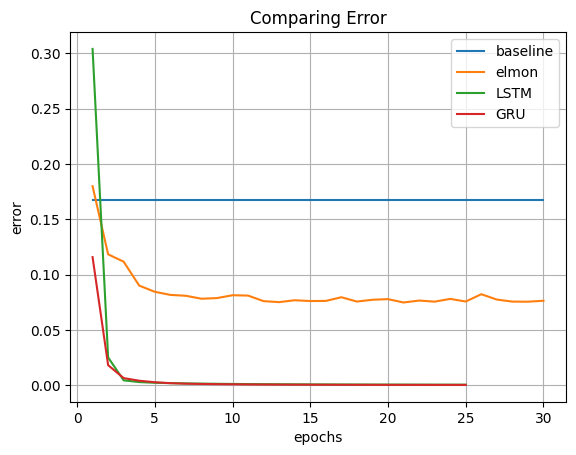

In [10]:
y = np.full(30,model_elmon.error_baseline)
x = np.arange(1,31,1)
plt.plot(x,y,label = 'baseline')
plt.plot(np.arange(1,model_elmon.noof_epochs+1,1),model_elmon.error_pred,label='elmon')
plt.plot(np.arange(1,model_LSTM.noof_epochs+1,1),model_LSTM.error_pred,label='LSTM')
plt.plot(np.arange(1,model_GRU.noof_epochs+1,1),model_GRU.error_pred,label='GRU')
plt.legend()
plt.title("Comparing Error")
plt.xlabel("epochs")
plt.ylabel("error")
plt.grid(True)
plt.show()

* The "elmon" model shows a higher error rate compared to both the "LSTM" and "GRU" models throughout the training epochs. This suggests that the "elmon" model struggles to learn and capture the patterns in the data effectively.
* Both the "LSTM" and "GRU" models converge faster and achieve lower error rates compared to the "elmon" model. This indicates that the LSTM and GRU models are more effective in learning and predicting the sums accurately.
* The "elmon" model performs better than the baseline model in terms of error rates, indicating its ability to learn and make predictions that are more accurate than always predicting a sum of 1.
* However, the "LSTM" and "GRU" models still outperform the "elmon" model, converging faster and achieving even lower error rates.

<p>The baseline model is the one that always predict sum as $1$ as the data is taken from uniform distribution and only two positions contains $1$ so $2*E[x] = 1$ so baseline model can be assumed to always output one</p>

<h3><center>Performance on same test dataset</center></h3>

In [11]:
model_elmon.test(nn.MSELoss(),x_test,y_test)

0.07604192085388832


In [12]:
model_LSTM.test(nn.MSELoss(),x_test,y_test)

0.00034890244498552646


In [13]:
model_GRU.test(nn.MSELoss(),x_test,y_test)

0.00010255258584867378


<h4>elmon Model:</h4>

* MSE Loss: 0.07604192085388832
* The elmon model achieves an MSE loss of approximately 0.076 on the test dataset.
* This indicates that, on average, the squared difference between the predicted outputs and the actual targets is 0.076. A lower MSE indicates better accuracy and closer predictions to the ground truth values.
* The elmon model's performance in testing suggests that it is able to make reasonably accurate predictions, although it may have higher errors compared to the LSTM and GRU models.

<h4>LSTM Model:</h4>

* MSE Loss: 0.00034890244498552646
* The LSTM model achieves an extremely low MSE loss of approximately 0.0003489 on the test dataset.
* This indicates that the LSTM model's predictions are very close to the actual targets, with minimal squared differences.
* The low MSE loss suggests that the LSTM model has learned to accurately capture the patterns in the data and make precise predictions.

<h4>GRU Model:</h4>

* MSE Loss: 0.00010255258584867378
* The GRU model achieves an even lower MSE loss of approximately 0.0001026 on the test dataset.
* This indicates that the GRU model's predictions are extremely close to the actual targets, with very small squared differences.
* The exceptionally low MSE loss suggests that the GRU model performs even better than the LSTM model in terms of accuracy and precision.

<p>Overall, the testing results show that both the LSTM and GRU models outperform the elmon model in terms of accuracy, with the GRU model achieving the lowest MSE loss. These results align with the observations from the comparison plot, confirming that the LSTM and GRU models are more effective in making accurate predictions on the given task.</p>